# Binary prior

## Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import logging
logger = logging.getLogger()

## Model

- $p(x) = p_+ \delta_+(x) + p_- \delta_-(x)$
- infer $x$ from noisy observation $r,v$ or $a=\frac{1}{v},b=\frac{r}{v}$
- $Z = \int dx\, p(x) e^{-\frac{1}{2} a x^2 + b x}$

In [2]:
from tramp.priors import BinaryPrior

## Posterior

In [3]:
def run_posterior(p_pos, r, v):
    prior = BinaryPrior(size=1, p_pos=p_pos)
    a, b = 1/v, r/v
    rx, vx = prior.compute_forward_posterior(a, b)
    return dict(a=a, b=b, rx=rx, vx=vx)

In [4]:
from ml_physics_utils import Task, DataFrameResultHandler
from ml_physics_utils.notebook import progressbar
from ml_physics_utils.plot import qplot
logger.setLevel(logging.ERROR)


result_handler = DataFrameResultHandler()
task = Task(run_posterior, p_pos=0.5, v = [0.5, 2], r = np.linspace(-3,3,101))
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

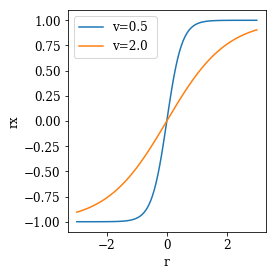

In [5]:
qplot(df, x="r", y="rx", color="v")

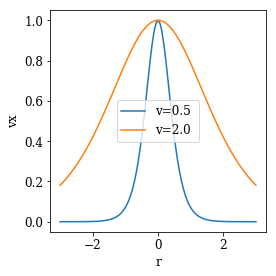

In [6]:
qplot(df, x="r", y="vx", color="v")

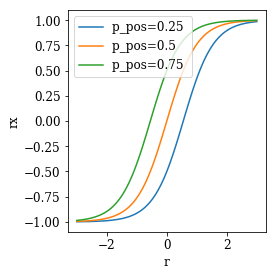

In [7]:
result_handler = DataFrameResultHandler()
task = Task(run_posterior, p_pos=[0.25, 0.5, 0.75], v = 1, r = np.linspace(-3,3,101))
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()

qplot(df, x="r", y="rx", color="p_pos")

In [8]:
df.query("r==0")

,a,b,p_pos,r,rx,v,vx
50,1.0,0.0,0.25,0.0,-0.5,1,0.75
151,1.0,0.0,0.50,0.0,0.0,1,1.00
252,1.0,0.0,0.75,0.0,0.5,1,0.75


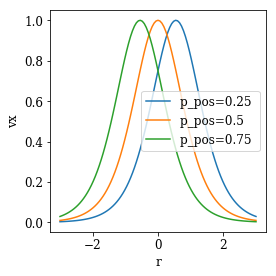

In [9]:
qplot(df, x="r", y="vx", color="p_pos")

## Error function

In [10]:
def run_error(p_pos, v):
    prior = BinaryPrior(size=1, p_pos=p_pos)
    a = 1/v
    error = prior.compute_forward_error(a)
    return dict(a=a, error=error)

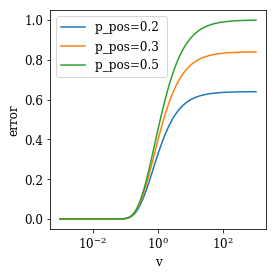

In [11]:
result_handler = DataFrameResultHandler()
task = Task(run_error, p_pos=[0.2, 0.3, 0.5], v = 10**np.linspace(-3,3,101))
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()
qplot(df, x="v", y="error", color="p_pos", xlog=True)

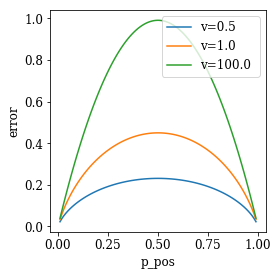

In [12]:
result_handler = DataFrameResultHandler()
task = Task(run_error, p_pos=np.linspace(0,1,101)[1:-1], v = [0.5, 1., 100.])
task.run(result_handler, on_progress=None)
df = result_handler.get_dataframe()
qplot(df, x="p_pos", y="error", color="v")

## Numerical stability

Seems okay

In [13]:
# test initial condition a=b=0
for p_pos in [0.5, 0.3]:
    binary = BinaryPrior(size=1, p_pos=p_pos)
    print(binary)
    print(binary.compute_forward_posterior(ax=1e-15, bx=1e-15))
    print(binary.compute_forward_posterior(ax=0, bx=0))
    print(binary.compute_forward_posterior(ax=1e-15, bx=0))
    print(binary.compute_forward_error(ax=1e-15))
    print(binary.compute_forward_error(ax=0)) # slight error but okay
    print()

BinaryPrior(size=1,p_pos=0.5)
(1.0000000000000001e-15, 1.0)
(0.0, 1.0)
(0.0, 1.0)
0.9999999999999993
1.0000000000000002

BinaryPrior(size=1,p_pos=0.3)
(-0.39999999999999913, 0.84000000000000075)
(-0.39999999999999997, 0.84000000000000008)
(-0.39999999999999997, 0.84000000000000008)
0.8399999999999992
0.8400000000000004

